# Biphasic Axon Map Phosphene Model

Notebook requirements:
cython
pulse2percept
matplotlib
numpy
scikit-learn
scipy
pandas

To install pulse2percept:


In [ ]:
!pip install git+https://github.com/pulse2percept/pulse2percept.git

## Setup

Run the following three cells to define the model 

In [3]:
%load_ext cython

In [6]:
%%cython
import numpy as np
cimport numpy as cnp
cimport cython
from cython import cdivision  # for modulo operator
from cython.parallel import prange
from libc.math cimport(pow as c_pow, exp as c_exp, tanh as c_tanh,
                       sin as c_sin, cos as c_cos, fabs as c_abs)

ctypedef cnp.float32_t float32
ctypedef cnp.uint32_t uint32
ctypedef cnp.int32_t int32
cdef float32 deg2rad = 3.14159265358979323846 / 180.0

@cython.boundscheck(False)
@cdivision(True)
cpdef fast_biphasic_axon_map(const float32[::1] amp_el,
                    const float32[::1] bright_model_el,
                    const float32[::1] size_model_el,
                    const float32[::1] streak_model_el,
                    const float32[::1] xel,
                    const float32[::1] yel,
                    const float32[:, ::1] axon_segments,
                    const uint32[::1] idx_start,
                    const uint32[::1] idx_end,
                    float32 rho,
                    float32 thresh_percept,
                    int32 timesteps):
    """Fast spatial response of the biphasic axon map model
    Predicts representative percept using entire time interval, 
    and returns this percept repeated at each time point
    Parameters
    ----------
    amp_el : 1D float array 
        Amplitudes (as a factor of threshold) per electrode
    bright_model_el, size_model_el, streak_model_el : 1D float array
        Factors by which to scale brightness, rho (size), and lambda (streak length)
    xel, yel : 1D float32 array
        An array of x or y coordinates for each electrode (microns)
    axon_segments : 2D float32 array
        All axon segments concatenated into an Nx3 array.
        Each row has the x/y coordinate of a segment along with its
        contribution to a given pixel.
        ``idx_start`` and ``idx_end`` are used to slice the ``axon`` array.
        For example, the axon belonging to the i-th pixel has segments
        axon[idx_start[i]:idx_end[i]].
        This arrangement is necessary in order to access ``axon`` in parallel.
    idx_start, idx_end : 1D uint32 array
        Start and stop indices of the i-th axon.
    rho : float32
        The rho parameter of the axon map model: exponential decay constant
        (microns) away from the axon.
        Note that lambda was already taken into account when calculating the
        axon contribution (stored/passed in ``axon``).
    thresh_percept : float32
        Spatial responses smaller than ``thresh_percept`` will be set to zero
    timesteps : float32
        The number of timesteps in the stimulus.

    Return Value
    -----------------
    A percept object representing the predicted brightest frame of the phosphene. 
    The percept has the same timepoints as the stimulus (for compatibility), but
    is exactly the same at every point in time. 
    """
    cdef:
        int32 idx_el, idx_time, idx_space, idx_ax, idx_bright
        int32 n_el, n_time, n_space, n_ax, n_bright
        float32[::1] bright
        float32 px_bright, xdiff, ydiff, r2, amp, gauss_el, gauss_soma 
        float32 sgm_bright, bright_effect, size_effect, streak_effect
        int32 i0, i1

    n_el = xel.shape[0]
    n_time = timesteps
    n_space = len(idx_start)
    n_bright = n_time * n_space

    # An array containing n_space entries
    bright = np.empty((n_space), dtype=np.float32)  # Py overhead

    # Parallel loop over all pixels to be rendered:
    for idx_space in prange(n_space, schedule='static', nogil=True):
        # Find the brightness value of each pixel (`px_bright`) by finding
        # the strongest activated axon segment:
        px_bright = 0.0
        # Slice `axon_contrib` (but don't assign the slice to a variable).
        # `idx_start` and `idx_end` serve as indexes into `axon_segments`.
        # For example, the axon belonging to the neuron sitting at pixel
        # `idx_space` has segments
        # `axon_segments[idx_start[idx_space]:idx_end[idx_space]]`:
        for idx_ax in range(idx_start[idx_space], idx_end[idx_space]):
            # Calculate the activation of each axon segment by adding up
            # the contribution of each electrode:
            sgm_bright = 0.0
            for idx_el in range(n_el):
                amp = amp_el[idx_el]
                bright_effect = bright_model_el[idx_el]
                size_effect = size_model_el[idx_el]
                streak_effect = streak_model_el[idx_el]
                if c_abs(amp) > 0:
                    # Calculate the distance between this axon segment and
                    # the center of the stimulating electrode:
                    xdiff = axon_segments[idx_ax, 0] - xel[idx_el]
                    ydiff = axon_segments[idx_ax, 1] - yel[idx_el]
                    r2 = xdiff * xdiff + ydiff * ydiff
                    # Determine the activation level of this axon segment,
                    # consisting of two things:
                    # - activation as a function of distance to the
                    #   stimulating electrode (depends on `rho`):
                    gauss_el = c_exp(-r2 / (2.0 * rho * rho * size_effect))
                    # - activation as a function of distance to the cell
                    #   soma (depends on `axlambda`, precalculated during
                    #   `build` and stored in `axon_segments[idx_ax, 2]`
                    #   precalculated value does not include streak model
                    #   effect, which must be added now
                    gauss_soma = c_pow(axon_segments[idx_ax, 2], 1 / streak_effect)
                    sgm_bright = (sgm_bright +
                                    bright_effect * gauss_el * gauss_soma)
            # After summing up the currents from all the electrodes, we
            # compare the brightness of the segment (`sgm_bright`) to the
            # previously brightest segment. The brightest segment overall
            # determines the brightness of the pixel (`px_bright`):
            if c_abs(sgm_bright) > c_abs(px_bright):
                px_bright = sgm_bright
        if c_abs(px_bright) < thresh_percept:
            px_bright = 0.0
        bright[idx_space] = px_bright  # Py overhead
    return np.asarray(np.transpose(np.tile(bright, (n_time, 1)))) # Copy output for each timestep

In [23]:
"""`BiphasicAxonMapModel`""" 
import numpy as np

from pulse2percept.models import AxonMapModel, AxonMapSpatial, TemporalModel, Model
from pulse2percept.implants import ProsthesisSystem, ElectrodeArray
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.datasets import load_nanduri2012

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings("ignore")

class DefaultBrightModel(): 
    # F_{bright}
    def __init__(self,  do_thresholding=True):
        self.amp_freq_model = LinearRegression()
        self.do_thresholding = do_thresholding

    def fit(self):
        self._fit_amp_freq()

    def _fit_amp_freq(self):
        # hard coded to linear regression parameters for now
        pass

    def predict_pdur(self, pdur): 
        # a tilde in paper
        # Fit using color threshold of weitz et al 2015, this is 1 / relative threshold, and amplitude will be scaled by this
        return 1 / (0.8825 + 0.27*pdur)
       
    def predict_freq_amp(self, amp, freq): 
        # return self.amp_freq_model.predict([(amp, freq)])[0]
        return 1.84*amp + 0.2*freq + 3.0986

    def __call__(self, amp, freq, pdur):
        bright = self.predict_freq_amp(amp * self.predict_pdur(pdur), freq) 

        # p = -1/96 + 97 / (96(1+96 exp(-ln(98)amp)))
        # Sigmoid with p[0] = 0, p[1] = 0.5, p[2] = 0.99
        p = -0.01041666666667 + 1.0104166666666667 / (1+96 * np.exp(-4.584967478670572 * amp * self.predict_pdur(pdur)))
        if not self.do_thresholding or np.random.random() < p:
            return bright
        else:
            return 0


class DefaultSizeModel():
    # F_{size}
    def __init__(self, rho):
        self.amp_model = LinearRegression()
        self.min_rho = 10 # dont let rho be scaled below this threshold
        self.min_scale = self.min_rho**2 / rho**2
    def fit(self):
        self._fit_amp()

    def _fit_amp(self):
        data = load_nanduri2012()
        data = data[data['task'] == 'size']
        x = data['amp_factor']
        y = data['size']
        self.amp_model.fit(np.array(x).reshape(-1, 1), y)
    
    def predict_pdur(self, pdur):
        # a tilde
        # Fit using color threshold of weitz et al 2015, technically this is 1 / threshold, and amplitude will be scaled by this
        return 1 / (0.8825 + 0.27*pdur)

    def __call__(self, amp, freq, pdur):
        scale = self.amp_model.predict(np.array([amp * self.predict_pdur(pdur)]).reshape(1, -1))[0] 
        if scale > self.min_scale:
            return scale
        else:
            return self.min_scale


class DefaultStreakModel():
    # F_{streak}
    def __init__(self, axlambda):
        # never decrease lambda to less than 10
        self.min_lambda = 10
        self.min_scale = self.min_lambda**2 / axlambda **2
    def __call__(self, amp, freq, pdur):
        # Fit using streak lengths measure from weitz et al 2015
        scale = 1.56 - 0.54 * pdur ** 0.21
        if scale > self.min_scale:
            return scale
        else:
            return self.min_scale




class BiphasicAxonMapSpatial(AxonMapSpatial):
    """
    AxonMapSpatial that scales percept size, brightness, and streak length according to
    the amplitude, frequency, and pulse duration of the BiphasicPulseTrain.

    All stimuli must be BiphasicPulseTrains.

    This model is different than other spatial models in that it calculates one percept from all time
    steps of the stimulus, and then returns this same percept at each time step. 

    The three new parameters are the models to be used to scale brightness, size, and streak length. 
    These models can be any python callable with function signature f(amp, freq, pdur) that returns a float.


    .. note: :

        Using this model in combination with a temporal model is not supported and will give unexpected results

    Parameters
    ----------
    bright_model: callable, optional
        Model used to modulate percept brightness with amplitude, frequency, and pulse duration
    size_model: callable, optional
        Model used to modulate percept size with amplitude, frequency, and pulse duration
    streak_model: callable, optional
        Model used to modulate percept streak length with amplitude, frequency, and pulse duration
    do_thresholding: boolean
        Use probabilistic sigmoid thresholding, default=True
    **params: dict, optional
        Arguments to be passed to AxonMapSpatial
    """

    def __init__(self, **params):
        super(BiphasicAxonMapSpatial, self).__init__(**params)
    
    def get_default_params(self):
        base_params = super(BiphasicAxonMapSpatial, self).get_default_params()
        params = {
            # Callable model used to modulate percept brightness with amplitude, frequency, and pulse duration
            'bright_model' : None, 
            # Callable model used to modulate percept size with amplitude, frequency, and pulse duration
            'size_model' : None, 
            # Callable model used to modulate percept streak length with amplitude, frequency, and pulse duration
            'streak_model' : None, 
            # Use probabilistic thresholding
            'do_thresholding' : False
        }
        params.update(base_params)
        return params

    def _build(self):
        # Fit models if needed 
        if self.bright_model is None:
            self.bright_model = DefaultBrightModel(do_thresholding=self.do_thresholding)
            self.bright_model.fit()
        if self.size_model is None:
            self.size_model = DefaultSizeModel(self.rho)
            self.size_model.fit()
        if self.streak_model is None:
            self.streak_model = DefaultStreakModel(self.axlambda)
        assert(callable(self.bright_model))
        assert(callable(self.size_model))
        assert(callable(self.streak_model))
        super(BiphasicAxonMapSpatial, self)._build()

    def _predict_spatial(self, earray, stim):
        """Predicts the percept"""
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        # Calculate model effects before losing GIL
        bright_effects = []
        size_effects = []
        streak_effects = []
        amps = []
        for e in stim.electrodes:
            amp = stim.metadata['electrodes'][str(e)]['metadata']['amp']
            freq = stim.metadata['electrodes'][str(e)]['metadata']['freq']
            pdur = stim.metadata['electrodes'][str(e)]['metadata']['phase_dur']
            bright_effects.append(self.bright_model(amp, freq, pdur))
            size_effects.append(self.size_model(amp, freq, pdur))
            streak_effects.append(self.streak_model(amp, freq, pdur))
            amps.append(amp)
                          
        # print(np.max(np.array([bright_effects, size_effects, streak_effects])))
        return fast_biphasic_axon_map(np.array(amps, dtype=np.float32),
                                      np.array(bright_effects, dtype=np.float32),
                                      np.array(size_effects, dtype=np.float32),
                                      np.array(streak_effects, dtype=np.float32),
                                      np.array([earray[e].x for e in stim.electrodes],
                                            dtype=np.float32),
                                      np.array([earray[e].y for e in stim.electrodes],
                                            dtype=np.float32),
                                      self.axon_contrib,
                                      self.axon_idx_start.astype(np.uint32),
                                      self.axon_idx_end.astype(np.uint32),
                                      self.rho,
                                      self.thresh_percept,
                                      stim.shape[1])

class BiphasicAxonMapModel(Model):
    """
    AxonMapModel that scales percept size, brightness, and streak length according to
    the amplitude, frequency, and pulse duration of the BiphasicPulseTrain.

    All stimuli must be BiphasicPulseTrains with no delay dur.

    This model is different than other spatial models in that it calculates the brightest percept 
    from all time steps of the stimulus, and then returns this same percept at each time step. 

    The three new parameters are the models to be used to scale brightness, size, and streak length. 
    These models can be any python callable with function signature f(amp, freq, pdur) that return a float.


    .. note: :

        Using this model in combination with a temporal model is not supported and may give unexpected results

    Parameters
    ----------
    bright_model: callable, optional
        Model used to modulate percept brightness with amplitude, frequency, and pulse duration
    size_model: callable, optional
        Model used to modulate percept size with amplitude, frequency, and pulse duration
    streak_model: callable, optional
        Model used to modulate percept streak length with amplitude, frequency, and pulse duration
    do_thresholding: boolean
        Use probabilistic sigmoid thresholding, default=True
    **params: dict, optional
        Arguments to be passed to AxonMapModel
    """
    def __init__(self, **params):
        super(BiphasicAxonMapModel, self).__init__(spatial=BiphasicAxonMapSpatial(),
                                           temporal=None, **params)

    def predict_percept(self, implant, t_percept=None):
        # Make sure stimulus is a BiphasicPulseTrain:
        if not isinstance(implant.stim, BiphasicPulseTrain):
            # Could still be a stimulus where each electrode has a biphasic pulse train
            for ele, params in implant.stim.metadata['electrodes'].items():
                if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                    raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
        return super(BiphasicAxonMapModel, self).predict_percept(implant,
                                                         t_percept=t_percept)
    

## Example

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

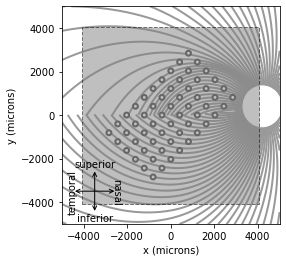

In [24]:
from pulse2percept.implants import ArgusII
implant = ArgusII(rot=45)
# model can still be tuned by overriding lambda and rho
model = BiphasicAxonMapModel(axlambda=500, rho=100)
model.build()
implant.plot()
model.plot()

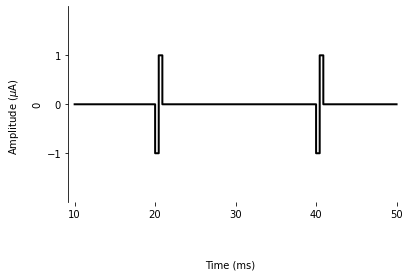

In [25]:
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
stim1 = BiphasicPulseTrain(50, 1, 0.45)
stim2 = BiphasicPulseTrain(25, 1, 0.1)
stim1.plot(time=(10, 50))

stim = Stimulus({'A3' : stim1, 'F8' : stim2})
implant.stim = stim

<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

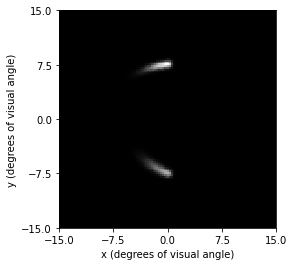

In [26]:
percept = model.predict_percept(implant)
percept.plot()

## Plots from EMBC 2021 paper

### Figure 3

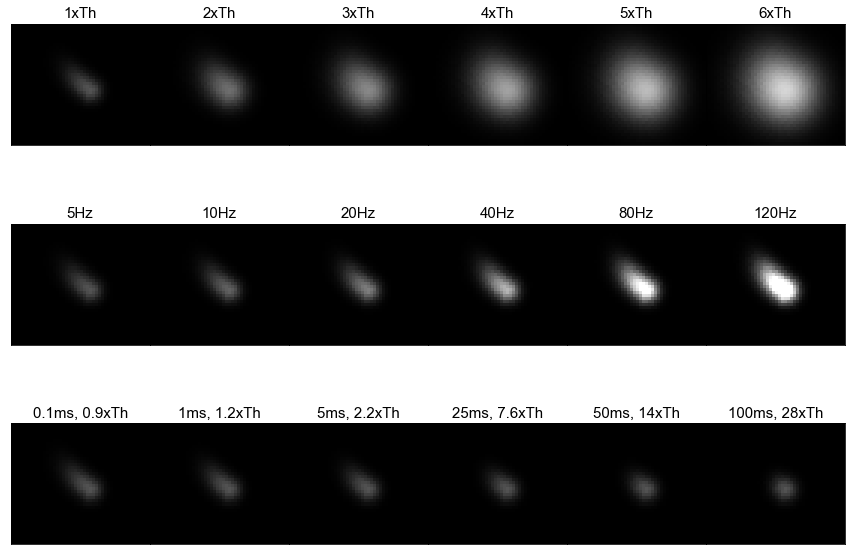

In [28]:
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import ProsthesisSystem, DiskElectrode
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
font = {'fontname':'Arial'}

import warnings
warnings.filterwarnings("ignore")


# gs1 = gridspec.GridSpec(5, 4)
# gs1.update(wspace=0.025, hspace=0.05)
fig, axes = plt.subplots(3, 6, sharex=True, sharey=True)#, gridspec_kw={'height_ratios': [2.5, 1, 1]})
# fig.subplots_adjust(wspace=0.23, hspace=-0.4)
fig.subplots_adjust(wspace=0, hspace=-0.35)

amps = [1, 2, 3, 4, 5, 6]
freqs = [5, 10, 20,40, 80, 120]
pdurs_1 = [0.1, 0.5, 1, 5, 10]
pdurs_2 = [.1, 1, 5, 25, 50, 100]
# ticks = [-6.0, -3.0, 0.0, 3.0]
plotborder = 1.5
ticks = []
model = BiphasicAxonMapModel(axlambda=400, rho=200, do_thresholding=False, yrange=(0, 10), xrange=(-6.5, 5))
model.build()
implant = ProsthesisSystem(DiskElectrode(0, 1500, 10, 200))

for i, amp in enumerate(amps):
    ax = axes[0, i]
    fig.sca(ax)
    stim = BiphasicPulseTrain(5, amp, 0.45)
    implant.stim = stim
    percept = model.predict_percept(implant)
    percept.plot(vmin=0, vmax=18, figsize=(11.5 * 1.3, 10 * 1.3))
    ax.set_title("" + str(amp) + "xTh", fontsize=15, **font)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 10)

    
for i, freq in enumerate(freqs):
    ax = axes[1,i]
    fig.sca(ax)
    stim = BiphasicPulseTrain(freq, 1, 0.45)
    implant.stim = stim
    percept = model.predict_percept(implant)
    percept.plot(vmin=0, vmax=18, figsize=(11.5 * 1.3, 10 * 1.3))
    ax.set_title("" + str(freq) + "Hz", fontsize=15, **font )
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 10)

    
    
for i, pdur in enumerate(pdurs_2):
    ax = axes[2,i]
    fig.sca(ax)
    amp = 1 / model.size_model.predict_pdur(pdur) # scale amp accordingly
    stim = BiphasicPulseTrain(5, amp, pdur)
    implant.stim = stim
    percept = model.predict_percept(implant)
    percept.plot(vmin=0, vmax=18, figsize=(11.5 * 1.3, 10 * 1.3))
    if amp > 10:
        ampstr = str(int(round(amp, 0)))
    else:
        ampstr = str(round(amp, 1))
    ax.set_title( str(pdur) + "ms, " + ampstr + "xTh", fontsize=15, **font)
    if i != 0:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_ylim(0, 10)

    
fig.show()

### Figure 4

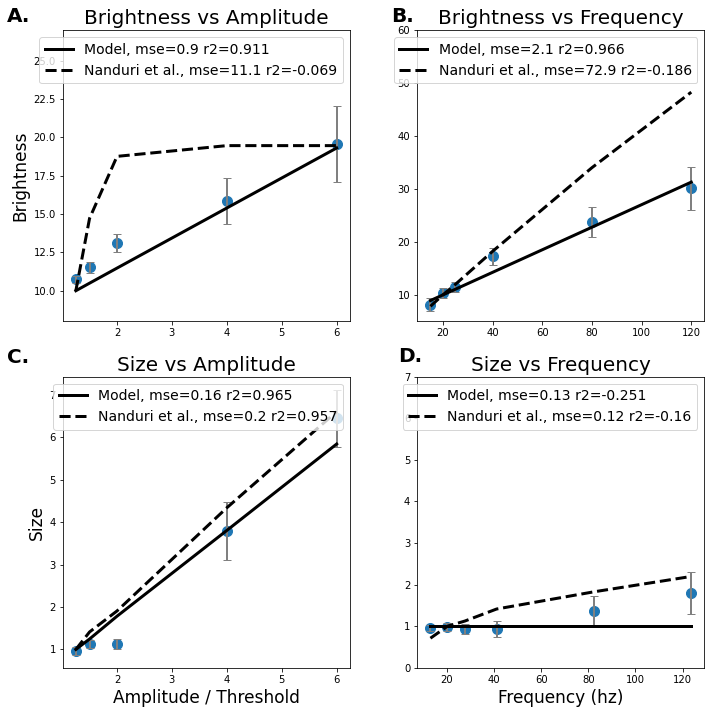

In [29]:
from pulse2percept.models import AxonMapModel, Nanduri2012Model
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusI
from pulse2percept.datasets import load_nanduri2012
from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
ax_fontsize=17
title_fontsize=20
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
linewidth=3
markersize=100
########################################################################################
fig.sca(axes[0,0])

df = load_nanduri2012()
df = df[(df['task'] == 'rate') & (df['varied_param'] == 'amp')]

uniq_amps = np.unique(df['amp_factor'])
avg_bright = [np.mean(df[df['amp_factor'] == a]['brightness']) for a in uniq_amps]
std_bright = [np.std(df[df['amp_factor'] == a]['brightness']) / np.sqrt(np.size(df[df['amp_factor'] == a]['brightness'])) for a in uniq_amps]

nanduri = Nanduri2012Model(xrange=(0, 0), yrange=(0, 0))
nanduri.build()
implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))

bam = BiphasicAxonMapModel(do_thresholding=False, xrange=(0, 0), yrange=(0, 0))
bam.build()

ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_bright_nanduri = nanduri.predict_percept(implant).data.max()
ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_bright_bam = bam.predict_percept(implant).data.max()

b_nan = []
b_bam = []
for amp in uniq_amps:
    stim = BiphasicPulseTrain(20, amp*30, 0.45, stim_dur=500)
    implant.stim = stim
    b_nan.append(nanduri.predict_percept(implant).data.max() / ref_bright_nanduri * 10)
    stim = BiphasicPulseTrain(20, amp, 0.45, stim_dur=500)
    implant.stim = stim
    b_bam.append(bam.predict_percept(implant).data.max() / ref_bright_bam * 10)
    
plt.title("Brightness vs Amplitude", fontsize=title_fontsize)
plt.annotate("A.", (0, 27.5), fontweight='bold', annotation_clip=False, fontsize=title_fontsize)
plt.ylim(8, 27)
plt.errorbar(uniq_amps, avg_bright, yerr=np.array(std_bright), linestyle='none', elinewidth=2, capsize=4, color='gray')
plt.scatter(uniq_amps, avg_bright, s=markersize)


msebam = np.mean((np.array(b_bam) - np.array(avg_bright))**2)
r2bam = r2_score(avg_bright, b_bam)
plt.plot(uniq_amps, b_bam, label='Model, mse=' + str(round(msebam, 1)) + " r2=" + str(round(r2bam, 3)), color='black', linewidth=linewidth)
msenan = np.mean((np.array(b_nan) - np.array(avg_bright))**2)
r2nan = r2_score(avg_bright, b_nan)
plt.plot(uniq_amps, b_nan, label='Nanduri et al., mse=' + str(round(msenan, 1))  + " r2=" + str(round(r2nan, 3)), color='black', linestyle='--', linewidth=linewidth)

plt.ylabel("Brightness", fontsize=ax_fontsize)
# plt.xlabel("Amplitude / Threshold", fontsize=ax_fontsize)
plt.legend(fontsize=14)

############################################################################################
fig.sca(axes[0,1])
df = load_nanduri2012()
df = df[(df['task'] == 'rate') & (df['varied_param'] == 'freq')]

uniq_freqs = np.unique(df['freq'])
avg_bright = [np.mean(df[df['freq'] == f]['brightness']) for f in uniq_freqs]
std_bright = [np.std(df[df['freq'] == f]['brightness']) / np.sqrt(np.size(df[df['freq'] == f]['brightness'])) for f in uniq_freqs]

nanduri = Nanduri2012Model(xrange=(0, 0), yrange=(0, 0))
nanduri.build()
implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))

bam = BiphasicAxonMapModel(do_thresholding=False, xrange=(0, 0), yrange=(0, 0))
bam.build()

ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_bright_nanduri = nanduri.predict_percept(implant).data.max()
ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_bright_bam = bam.predict_percept(implant).data.max()

b_nan = []
b_bam = []
for freq in uniq_freqs:
    stim = BiphasicPulseTrain(freq, 1.25*30, 0.45, stim_dur=500)
    implant.stim = stim
    b_nan.append(nanduri.predict_percept(implant).data.max() / ref_bright_nanduri * 10)
    stim = BiphasicPulseTrain(freq, 1.25, 0.45, stim_dur=500)
    implant.stim = stim
    b_bam.append(bam.predict_percept(implant).data.max() / ref_bright_bam * 10)
    
plt.title("Brightness vs Frequency", fontsize=title_fontsize)
plt.annotate("B.", (-0.75, 61.5), fontweight='bold', annotation_clip=False, fontsize=title_fontsize)
plt.ylim(5, 60)
plt.errorbar(uniq_freqs, avg_bright, yerr=np.array(std_bright), linestyle='none', elinewidth=2, capsize=4, color='gray')
plt.scatter(uniq_freqs, avg_bright, s=markersize)


msebam = np.mean((np.array(b_bam) - np.array(avg_bright))**2)
r2bam = r2_score(avg_bright, b_bam)
plt.plot(uniq_freqs, b_bam, label='Model, mse=' + str(round(msebam, 1)) + " r2=" + str(round(r2bam, 3)), color='black', linewidth=linewidth)
msenan = np.mean((np.array(b_nan) - np.array(avg_bright))**2)
r2nan = r2_score(avg_bright, b_nan)
plt.plot(uniq_freqs, b_nan, label='Nanduri et al., mse=' + str(round(msenan, 1))+ " r2=" + str(round(r2nan, 3)), color='black', linestyle='--', linewidth=linewidth)

# plt.ylabel("Brightness", fontsize=ax_fontsize)
# plt.xlabel("Frequency (hz)", fontsize=ax_fontsize)
plt.legend(fontsize=14)
##################################################################################################
# taken from nanduri fig 8
freqmod_ba = np.array([[8.417, 0.983],[12.333, 0.939],[17.708, 0.961],[23.542, 1.430],[29.458, 1.888]])
ampmod_ba = np.array([[10.042, 0.972], [11.333, 1.128],[14.125, 1.128],[15.917, 3.799],[19.000, 6.447]])

ampmod_amps = [1.25, 1.5, 2, 4, 6]
ampmod_freq = 20
freqmod_amp = 1.25
freqmod_freqs = [13, 27, 40, 80, 120]
sems = [0.093, 0.095, 0.108, 0.682, 0.675]
fig.sca(axes[1,0])
nanduri = Nanduri2012Model()
nanduri.build()
implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))

def get_size(percept, ref_bright=None):
    if ref_bright is None:
        ref_bright = (percept.get_brightest_frame().max() - percept.get_brightest_frame().min()) * 0.1 + percept.get_brightest_frame().min()
    return (percept.get_brightest_frame() > ref_bright).sum()

bam = BiphasicAxonMapModel(do_thresholding=False)
bam.build()

threshold_stim = BiphasicPulseTrain(20, 30, 0.45, stim_dur=500)
implant.stim = threshold_stim
bright_th_nan = nanduri.predict_percept(implant).get_brightest_frame().max()

ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_size_nanduri = get_size(nanduri.predict_percept(implant), ref_bright=bright_th_nan)
ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_size_bam = get_size(bam.predict_percept(implant))

b_nan = []
b_bam = []
for amp in ampmod_amps:
    stim = BiphasicPulseTrain(20, amp*30, 0.45, stim_dur=500)
    implant.stim = stim
    b_nan.append(get_size(nanduri.predict_percept(implant), ref_bright=bright_th_nan) / ref_size_nanduri )
    stim = BiphasicPulseTrain(20, amp, 0.45, stim_dur=500)
    implant.stim = stim
    b_bam.append(get_size(bam.predict_percept(implant)) / ref_size_bam)
    
plt.title("Size vs Amplitude", fontsize=title_fontsize)
plt.annotate("C.", (0, 7.75), fontweight='bold', annotation_clip=False, fontsize=title_fontsize)
plt.errorbar(ampmod_amps, np.array(ampmod_ba)[:, 1], yerr=np.array(sems), linestyle='none', elinewidth=2, capsize=4, color='gray')
plt.scatter(ampmod_amps, np.array(ampmod_ba)[:, 1], s=markersize)
# plt.errorbar(uniq_freqs, avg_bright, yerr=np.array(std_bright), linestyle='none', elinewidth=1, capsize=4)

msebam = np.mean((np.array(b_bam) - np.array(ampmod_ba)[:, 1])**2)
r2bam = r2_score(np.array(ampmod_ba)[:, 1], b_bam)
plt.plot(ampmod_amps, b_bam, label='Model, mse=' + str(round(msebam, 2))+ " r2=" + str(round(r2bam, 3)), color='black', linewidth=linewidth)
msenan = np.mean((np.array(b_nan) - np.array(ampmod_ba)[:, 1])**2)
r2nan = r2_score(np.array(ampmod_ba)[:, 1], b_nan)
plt.plot(ampmod_amps, b_nan, label='Nanduri et al., mse=' + str(round(msenan, 2))+ " r2=" + str(round(r2nan, 3)), color='black', linestyle='--', linewidth=linewidth)

plt.ylabel("Size", fontsize=ax_fontsize)
plt.xlabel("Amplitude / Threshold", fontsize=ax_fontsize)
plt.legend(fontsize=14)
################################################################################################################################
fig.sca(axes[1,1]) # extracted from nanduri et al 2012
sizes = [0.9583333333333321,0.9791666666666661,0.9374999999999982,0.9374999999999982,1.3541666666666643,1.7916666666666643]
freqs = [12.941176470588243, 20.16806722689076, 27.56302521008404, 41.00840336134455,82.18487394957984, 123.69747899159664]
sem_freqs = [.08, .102, .12, .193, .37, .5]

uniq_freqs = np.array(freqs)
std_size = np.array(sem_freqs) 

def get_size(percept, ref_bright=None):
    if ref_bright is None:
        ref_bright = (percept.get_brightest_frame().max() - percept.get_brightest_frame().min()) * 0.1 + percept.get_brightest_frame().min()
    return (percept.get_brightest_frame() > ref_bright).sum()

nanduri = Nanduri2012Model()
nanduri.build()
implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))

bam = BiphasicAxonMapModel(do_thresholding=False)
bam.build()

threshold_stim = BiphasicPulseTrain(20, 30, 0.45, stim_dur=500)
implant.stim = threshold_stim
bright_th_nan = nanduri.predict_percept(implant).get_brightest_frame().max()

ref_stim = BiphasicPulseTrain(20, 1.25*30, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_size_nanduri = get_size(nanduri.predict_percept(implant), ref_bright=bright_th_nan)
ref_stim = BiphasicPulseTrain(20, 1.25, 0.45, stim_dur=500)
implant.stim = ref_stim
ref_size_bam = get_size(bam.predict_percept(implant))

b_nan = []
b_bam = []
for freq in uniq_freqs:
    stim = BiphasicPulseTrain(freq, 1.25*30, 0.45, stim_dur=500)
    implant.stim = stim
    b_nan.append(get_size(nanduri.predict_percept(implant), ref_bright=bright_th_nan) / ref_size_nanduri )
    stim = BiphasicPulseTrain(freq, 1.25, 0.45, stim_dur=500)
    implant.stim = stim
    b_bam.append(get_size(bam.predict_percept(implant)) / ref_size_bam)
plt.annotate("D.", (-0.75, 7.35), fontweight='bold', annotation_clip=False, fontsize=title_fontsize)
plt.title("Size vs Frequency", fontsize=title_fontsize)
plt.errorbar(uniq_freqs, sizes, yerr=np.array(std_size), linestyle='none', elinewidth=2, capsize=4, color='gray')
plt.scatter(uniq_freqs, sizes, s=markersize)

msebam = np.mean((np.array(b_bam) - np.array(sizes))**2)
r2bam=r2_score(sizes, b_bam)
plt.plot(uniq_freqs, b_bam, label='Model, mse=' + str(round(msebam, 2))+ " r2=" + str(round(r2bam, 3)), color='black', linewidth=linewidth)
msenan = np.mean((np.array(b_nan) - np.array(sizes))**2)
r2nan=r2_score(sizes, b_nan)
plt.plot(uniq_freqs, b_nan, label='Nanduri et al., mse=' + str(round(msenan, 2))+ " r2=" + str(round(r2nan, 3)), color='black', linestyle='--', linewidth=linewidth)

# plt.ylabel("Size", fontsize=ax_fontsize)
plt.xlabel("Frequency (hz)", fontsize=ax_fontsize)
plt.ylim(0, 7)
plt.legend(fontsize=14)

#####################################################################
fig.tight_layout()
fig.show()

### Figure 5

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from pulse2percept.models import Nanduri2012Model
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusI
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit

df = pd.read_csv("greenwald.csv")

threshs = df['threshold']
amps = df['amp']
brights = df['brightness']
amp_factors = np.array(amps) / np.array(threshs)

implant = ProsthesisSystem(DiskElectrode(0, 0, 0, 260))
bam = BiphasicAxonMapModel(do_thresholding=False, xrange=(0, 0), yrange=(0, 0))
bam.build()
nanduri = Nanduri2012Model(xrange=(0, 0), yrange=(0, 0))
nanduri.build()

bnan = []
bbam = []

for i, amp, amp_factor, thresh, b in zip([i for i in range(len(amps))], amps, amp_factors, threshs, brights):
    ref_stim = BiphasicPulseTrain(1, 2.5, 0.975)
    implant.stim = ref_stim
    ref_bright = bam.predict_percept(implant).data.max()
    ref_stim = BiphasicPulseTrain(1, 2.5*thresh, 0.975)
    implant.stim = ref_stim
    ref_bright_nan = nanduri.predict_percept(implant).data.max()
    
    stim = BiphasicPulseTrain(1, amp_factor, 0.975)
    implant.stim=stim
    bright = bam.predict_percept(implant).data.max()
    stim = BiphasicPulseTrain(1, amp, 0.975)
    implant.stim=stim
    bright_nan = nanduri.predict_percept(implant).data.max()
    bbam.append(bright / ref_bright * 10)
    bnan.append(bright_nan / ref_bright_nan * 10)

plt.figure(figsize=(10,10))
# plt.title("Amplitude vs Brightness", fontsize=19)
plt.scatter(amp_factors, brights, s=60) 

mse = np.mean((bbam - np.array(brights))**2)
r2 = r2_score(brights, bbam)

temp = [i for i in sorted(zip(amp_factors, bbam)) if i[0] >= 0.0]
x = [t[0] for t in temp]
y = [t[1] for t in temp]

plt.plot(x, y, color='black', label='Model, mse=' + str(round(mse, 1)) + " r2=" + str(round(r2, 3)), linewidth=3)

mse_nan = np.mean((bnan - np.array(brights))**2)
r2 = r2_score(brights, bnan)
temp = [i for i in sorted(zip(amp_factors, bnan))]
x = [t[0] for t in temp]
y = [t[1] for t in temp]
plt.plot(x, y, color='black', label='Nanduri et al., mse=' + str(round(mse_nan, 1))+ " r2=" + str(round(r2, 3)), linestyle='--', linewidth=3)

l = LinearRegression()
l.fit(np.array(amp_factors).reshape(-1, 1), brights)
preds = l.predict(amp_factors.reshape(-1, 1))
mse_ls = np.mean((preds - np.array(brights))**2)
r2 = r2_score(brights, preds)

plt.plot(sorted(amp_factors), l.predict(np.array(sorted(amp_factors)).reshape(-1, 1)), label="Linear regression, mse=" + str(round(mse_ls, 1))+ " r2=" + str(round(r2, 3)), color='black', linestyle=':', linewidth=3)

# def f(x, a, b, c):
#     return a*x**b + c

# res = curve_fit(f, amp_factors, brights)
# preds_pow = [f(a, res[0][0], res[0][1], res[0][2]) for a in amp_factors]

# mse_pow = np.sum((preds_pow - np.array(brights))**2)

# temp = [i for i in sorted(zip(amp_factors, preds_pow))]
# x = [t[0] for t in temp]
# y = [t[1] for t in temp]

# plt.plot(x, y, color='black', label='Power fit, mse=' + str(round(mse_pow, 1)), linestyle='-.')

plt.ylabel("Brightness", fontsize=16)
# plt.yticks([10, 50, 100])
plt.xlabel("Amplitude / Threshold", fontsize=16)
plt.legend(fontsize=13)

plt.show()
